# Parkinson's Disease Telemonitoring

##### In this notebook I will look at a [dataset](https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring) composed of biomedical voice measurements from 42 people with early-stage Parkinson's disease.
##### The subjects were recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes.
##### Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures.
##### Each row corresponds to one of 5,875 voice recording from these individuals. 
##### The aim is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures.


Reference:<br>
Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009) <br>
'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests' <br>
[IEEE](https://ieeexplore.ieee.org/document/5339170) Transactions on Biomedical Engineering

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from zlib import crc32
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Set directory to save the data
DATA_DIR = "../data/raw"

##### Fetching the data:

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# data (as pandas dataframes)
X_all = parkinsons_telemonitoring.data.features
y_all = parkinsons_telemonitoring.data.targets

# concat for easier train-test split
parkinsons_all = pd.concat([X_all, y_all], axis=1)

# metadata
print(parkinsons_telemonitoring.metadata)

# variable information
print(parkinsons_telemonitoring.variables)

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'published_in': 'IEEE Transactions on Biomedical Engineering', 

In [4]:
parkinsons_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5875 non-null   int64  
 1   test_time      5875 non-null   float64
 2   Jitter(%)      5875 non-null   float64
 3   Jitter(Abs)    5875 non-null   float64
 4   Jitter:RAP     5875 non-null   float64
 5   Jitter:PPQ5    5875 non-null   float64
 6   Jitter:DDP     5875 non-null   float64
 7   Shimmer        5875 non-null   float64
 8   Shimmer(dB)    5875 non-null   float64
 9   Shimmer:APQ3   5875 non-null   float64
 10  Shimmer:APQ5   5875 non-null   float64
 11  Shimmer:APQ11  5875 non-null   float64
 12  Shimmer:DDA    5875 non-null   float64
 13  NHR            5875 non-null   float64
 14  HNR            5875 non-null   float64
 15  RPDE           5875 non-null   float64
 16  DFA            5875 non-null   float64
 17  PPE            5875 non-null   float64
 18  sex     

- We have 19 features and two targets (motor_UPDRS and total_UPDRS)
- No missing data
- 'sex' is a binary variable (0: male, 1: female), 'age' is an integer, and the remainder are floats.

### First, we must separate out a test set
#### Two methods are:
1)  Compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to x% of the maximum hash value.
2) Use stratified sampling to ensure that the relative proportions of particular instances are preserved between sets, e.g. 'age' and 'sex'.

In [5]:
# Method 1.
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


# We will use the dataframe index as there is no other identifier in this data set:
parkinsons_all_with_id = parkinsons_all.reset_index()
train_set_hash, test_set_hash = split_train_test_by_id(
    parkinsons_all_with_id, 0.2, "index"
)


# Method 2.
# We will use stratified sampling based on the 'age' and 'sex' features:
df_train, df_test = train_test_split(
    parkinsons_all_with_id, test_size=0.2, stratify=X_all[["age", "sex"]]
)

In [6]:
def proportions(data: pd.DataFrame, column: str) -> pd.Series:
    return data[column].value_counts() / len(data)

#### Now let's compare the sampling bias of the Hash and Stratified approaches:

In [7]:
col = "sex"
compare_props = pd.DataFrame(
    {
        "Overall": proportions(parkinsons_all_with_id, col),
        "Stratified": proportions(df_test, col),
        "Hash": proportions(test_set_hash, col),
    }
).sort_index()
compare_props["Hash. %error"] = (
    100 * compare_props["Hash"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)
compare_props

,Overall,Stratified,Hash,Hash. %error,Strat. %error
sex,,,,,
0,0.682213,0.681702,0.685957,0.548902,-0.074850
1,0.317787,0.318298,0.314043,-1.178361,0.160686


In [8]:
col = "age"
compare_props = pd.DataFrame(
    {
        "Overall": proportions(parkinsons_all_with_id, col),
        "Stratified": proportions(df_test, col),
        "Hash": proportions(test_set_hash, col),
    }
).sort_index()
compare_props["Hash. %error"] = (
    100 * compare_props["Hash"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)
compare_props

,Overall,Stratified,Hash,Hash. %error,Strat. %error
age,,,,,
36,0.017191,0.017021,0.018723,8.910891,-9.900990e-01
49,0.043574,0.043404,0.040851,-6.250000,-3.906250e-01
55,0.045447,0.045106,0.049362,8.614232,-7.490637e-01
56,0.023830,0.023830,0.022128,-7.142857,-1.421085e-14
57,0.065532,0.065532,0.064681,-1.298701,0.000000e+00
58,0.073021,0.073191,0.072340,-0.932401,2.331002e-01
59,0.050894,0.051064,0.051064,0.334448,3.344482e-01
60,0.026553,0.026383,0.026383,-0.641026,-6.410256e-01
61,0.025532,0.025532,0.025532,0.000000,0.000000e+00


### We will adopt the stratified approach and save the data sets to train and test csvs:

In [152]:
#df_train.to_csv(f"{DATA_DIR}/parkinsons_train.csv", index=False)
#df_test.to_csv(f"{DATA_DIR}/parkinsons_test.csv", index=False)

### Loading the saved train_set and dropping the "index" column we previously created.
#### We will focus on predicting the motor_UPDRS and so will also drop total_UPDRS for now.

In [64]:
data = pd.read_csv(f"{DATA_DIR}/parkinsons_train.csv")
data = data.drop(columns=["index", "total_UPDRS"])
data.head()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
0,74,97.324,0.00736,0.000042,0.00342,0.00299,0.01025,0.02320,0.236,0.00971,0.01254,0.01831,0.02914,0.048427,21.157,0.66519,0.72468,0.24595,1,30.390
1,66,119.390,0.00644,0.000045,0.00279,0.00358,0.00838,0.03013,0.272,0.01439,0.01953,0.02625,0.04317,0.030187,22.016,0.60621,0.58043,0.29198,0,32.248
2,75,20.363,0.01152,0.000090,0.00410,0.00577,0.01229,0.07510,0.698,0.02143,0.04029,0.11435,0.06430,0.046100,15.471,0.66430,0.77399,0.41223,0,28.039
3,74,174.320,0.00766,0.000044,0.00383,0.00400,0.01149,0.02359,0.240,0.00962,0.01185,0.01764,0.02886,0.039169,20.763,0.61052,0.75350,0.29911,1,22.960
4,72,50.301,0.00587,0.000055,0.00215,0.00308,0.00645,0.03121,0.291,0.01499,0.01814,0.02322,0.04497,0.027997,21.214,0.52511,0.58654,0.21624,0,16.623


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            4700 non-null   int64  
 1   test_time      4700 non-null   float64
 2   Jitter(%)      4700 non-null   float64
 3   Jitter(Abs)    4700 non-null   float64
 4   Jitter:RAP     4700 non-null   float64
 5   Jitter:PPQ5    4700 non-null   float64
 6   Jitter:DDP     4700 non-null   float64
 7   Shimmer        4700 non-null   float64
 8   Shimmer(dB)    4700 non-null   float64
 9   Shimmer:APQ3   4700 non-null   float64
 10  Shimmer:APQ5   4700 non-null   float64
 11  Shimmer:APQ11  4700 non-null   float64
 12  Shimmer:DDA    4700 non-null   float64
 13  NHR            4700 non-null   float64
 14  HNR            4700 non-null   float64
 15  RPDE           4700 non-null   float64
 16  DFA            4700 non-null   float64
 17  PPE            4700 non-null   float64
 18  sex     

In [66]:
data.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
count,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000
mean,64.803830,92.918207,0.006093,0.000044,0.002953,0.003238,0.008859,0.034049,0.310728,0.017177,0.020169,0.027416,0.051531,0.031945,21.703570,0.541524,0.653091,0.218905,0.317872,21.301757
std,8.825869,53.139164,0.005329,0.000036,0.002956,0.003502,0.008867,0.026058,0.231438,0.013401,0.016836,0.019582,0.040203,0.059836,4.285819,0.100600,0.070667,0.090413,0.465699,8.138566
min,36.000000,-4.262500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003790,0.034000,0.001780,0.002220,0.002920,0.005330,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000,5.037700
25%,58.000000,47.374000,0.003570,0.000022,0.001570,0.001820,0.004720,0.019200,0.175000,0.009350,0.010797,0.015607,0.028055,0.010895,19.411250,0.470112,0.595800,0.156460,0.000000,15.000000
50%,65.000000,91.754000,0.004880,0.000034,0.002230,0.002470,0.006685,0.027370,0.252000,0.013580,0.015780,0.022670,0.040730,0.018427,21.991000,0.542255,0.643385,0.204625,0.000000,20.947000
75%,72.000000,137.870000,0.006790,0.000053,0.003280,0.003440,0.009840,0.039680,0.364000,0.020510,0.023705,0.032762,0.061525,0.031452,24.514000,0.614088,0.711355,0.265153,1.000000,27.598000
max,85.000000,215.490000,0.099620,0.000446,0.054510,0.056890,0.163520,0.268630,2.107000,0.162670,0.167020,0.247110,0.488020,0.748260,37.875000,0.966080,0.836270,0.677900,1.000000,39.511000


### First look at the distributions:

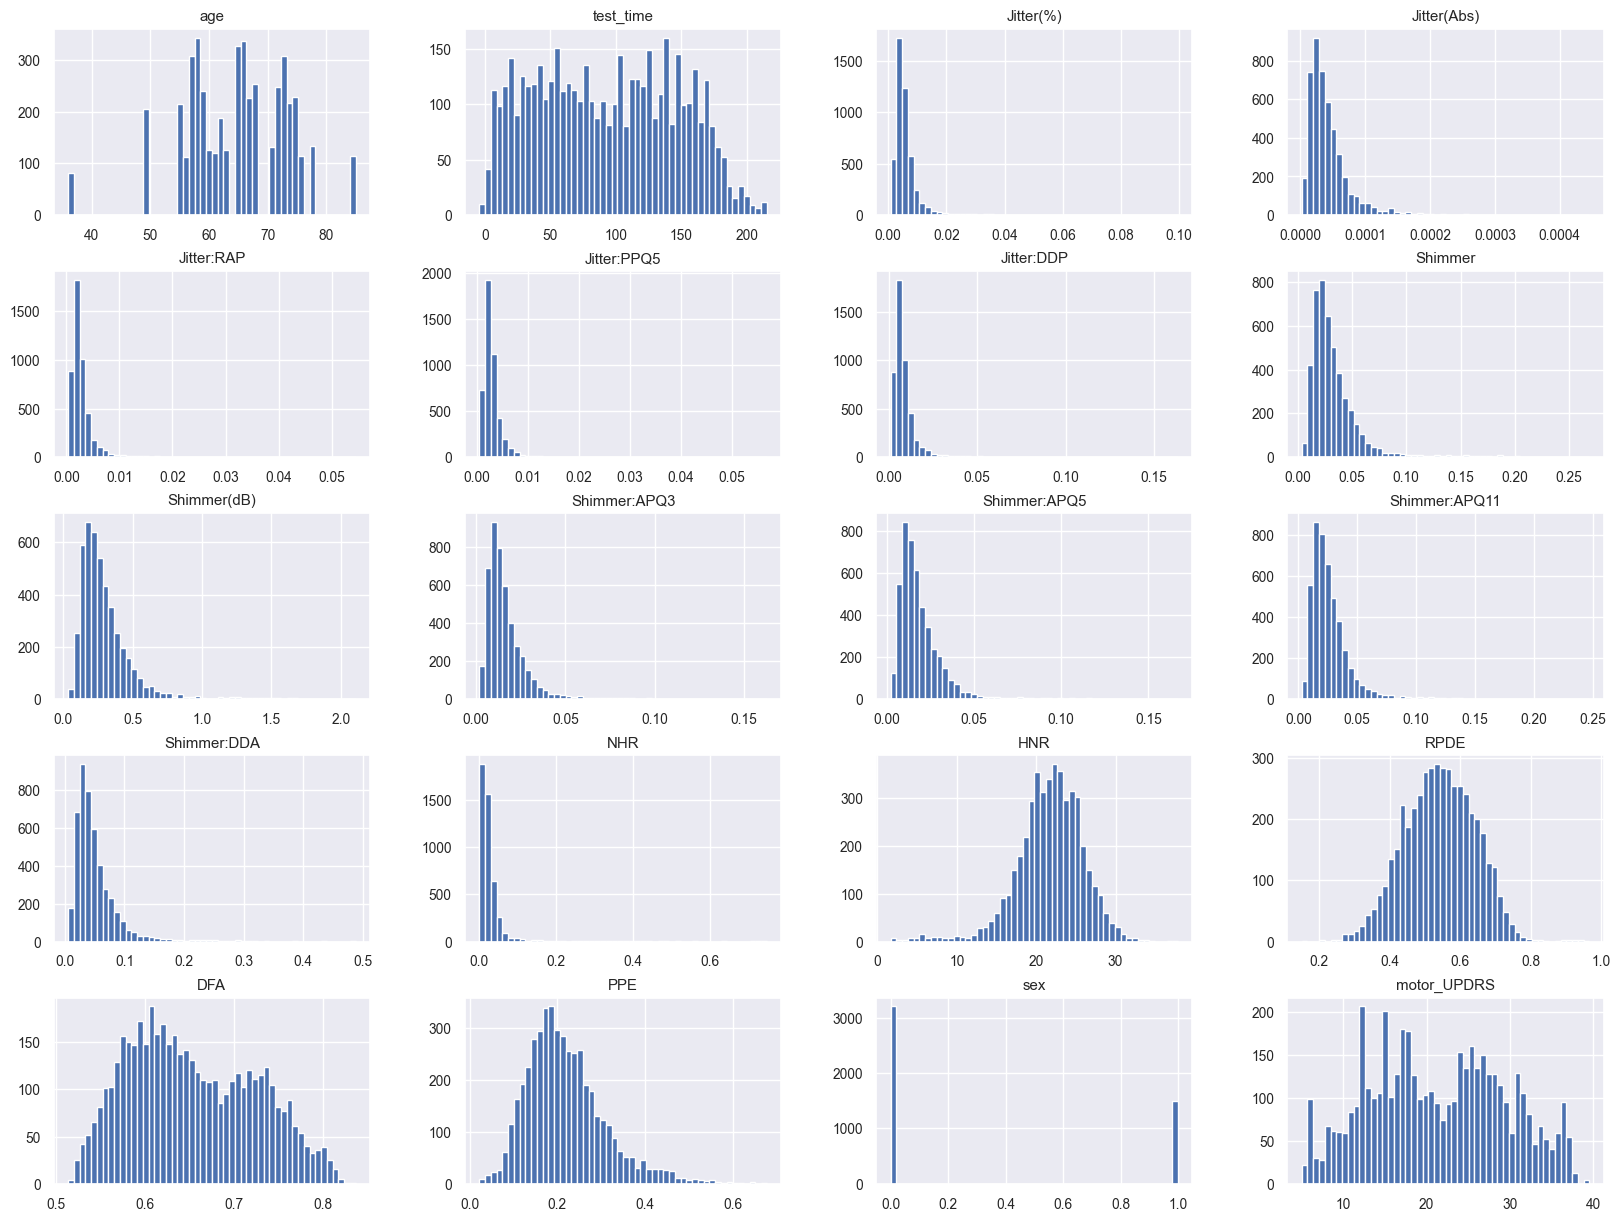

In [67]:
data.hist(bins=50, figsize=(20, 15));

- We see a number of right-hand skewed distributions
- DFA is double-peaked
- There are approximately twice as many males as females in the trial

### Correlations

In [68]:
# Compute Pearson's r correlation coefficient
corr_matrix = data.corr()

In [70]:
corr_matrix["motor_UPDRS"].sort_values(ascending=False)

motor_UPDRS      1.000000
age              0.277383
PPE              0.164473
Shimmer:APQ11    0.132048
RPDE             0.127957
Shimmer(dB)      0.104552
Shimmer          0.096318
Shimmer:APQ5     0.086529
Shimmer:DDA      0.079218
Shimmer:APQ3     0.079215
Jitter(%)        0.078771
Jitter:PPQ5      0.070581
NHR              0.069793
test_time        0.066799
Jitter:DDP       0.064640
Jitter:RAP       0.064636
Jitter(Abs)      0.048834
sex             -0.031355
DFA             -0.116819
HNR             -0.156137
Name: motor_UPDRS, dtype: float64

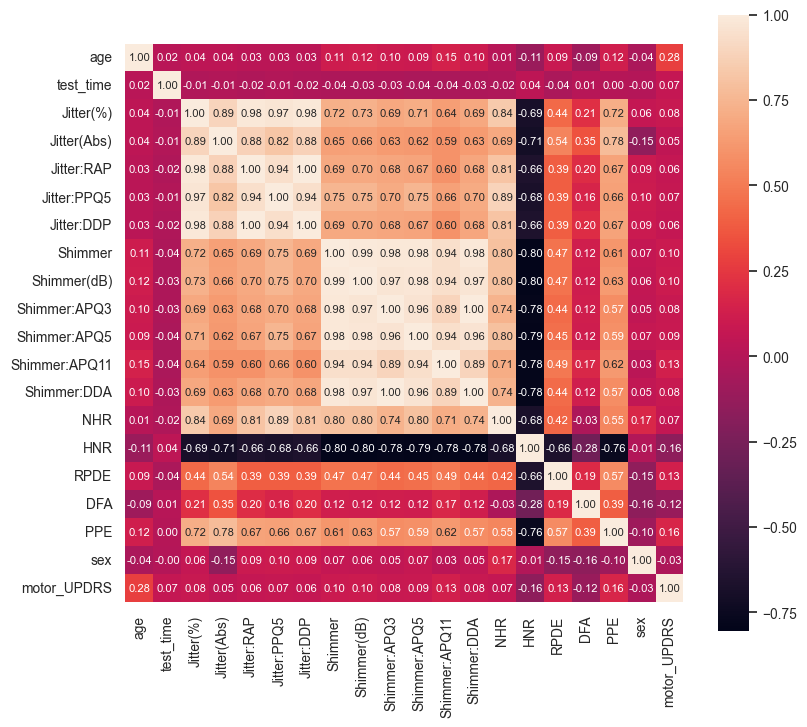

In [71]:
fig, ax = plt.subplots(figsize=(9,8))  
sns.set(font_scale=0.9)
sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8});


#### None of the measures have a large magnitude correlation with motor_UPDRS
#### However, it is evident that we have issues of multicollinearity between variables, which is not surprising given that we have many variants of jitter and shimmer.
#### We will likely want to experiment with eliminating some features, applying regularization, or applying PCA.
#### In the paper referenced at the top of this notebook, the authors found that six features (Jitter (Abs), Shimmer, NHR, HNR, DFA and PPE) gave the best balance between prediction accuracy and model complexity.

### Let's select some features and plot them against one another, showing male/female in different colours:

In [72]:
features = ["motor_UPDRS", "age", "PPE", "RPDE", "Shimmer:APQ11", "HNR", "sex"]

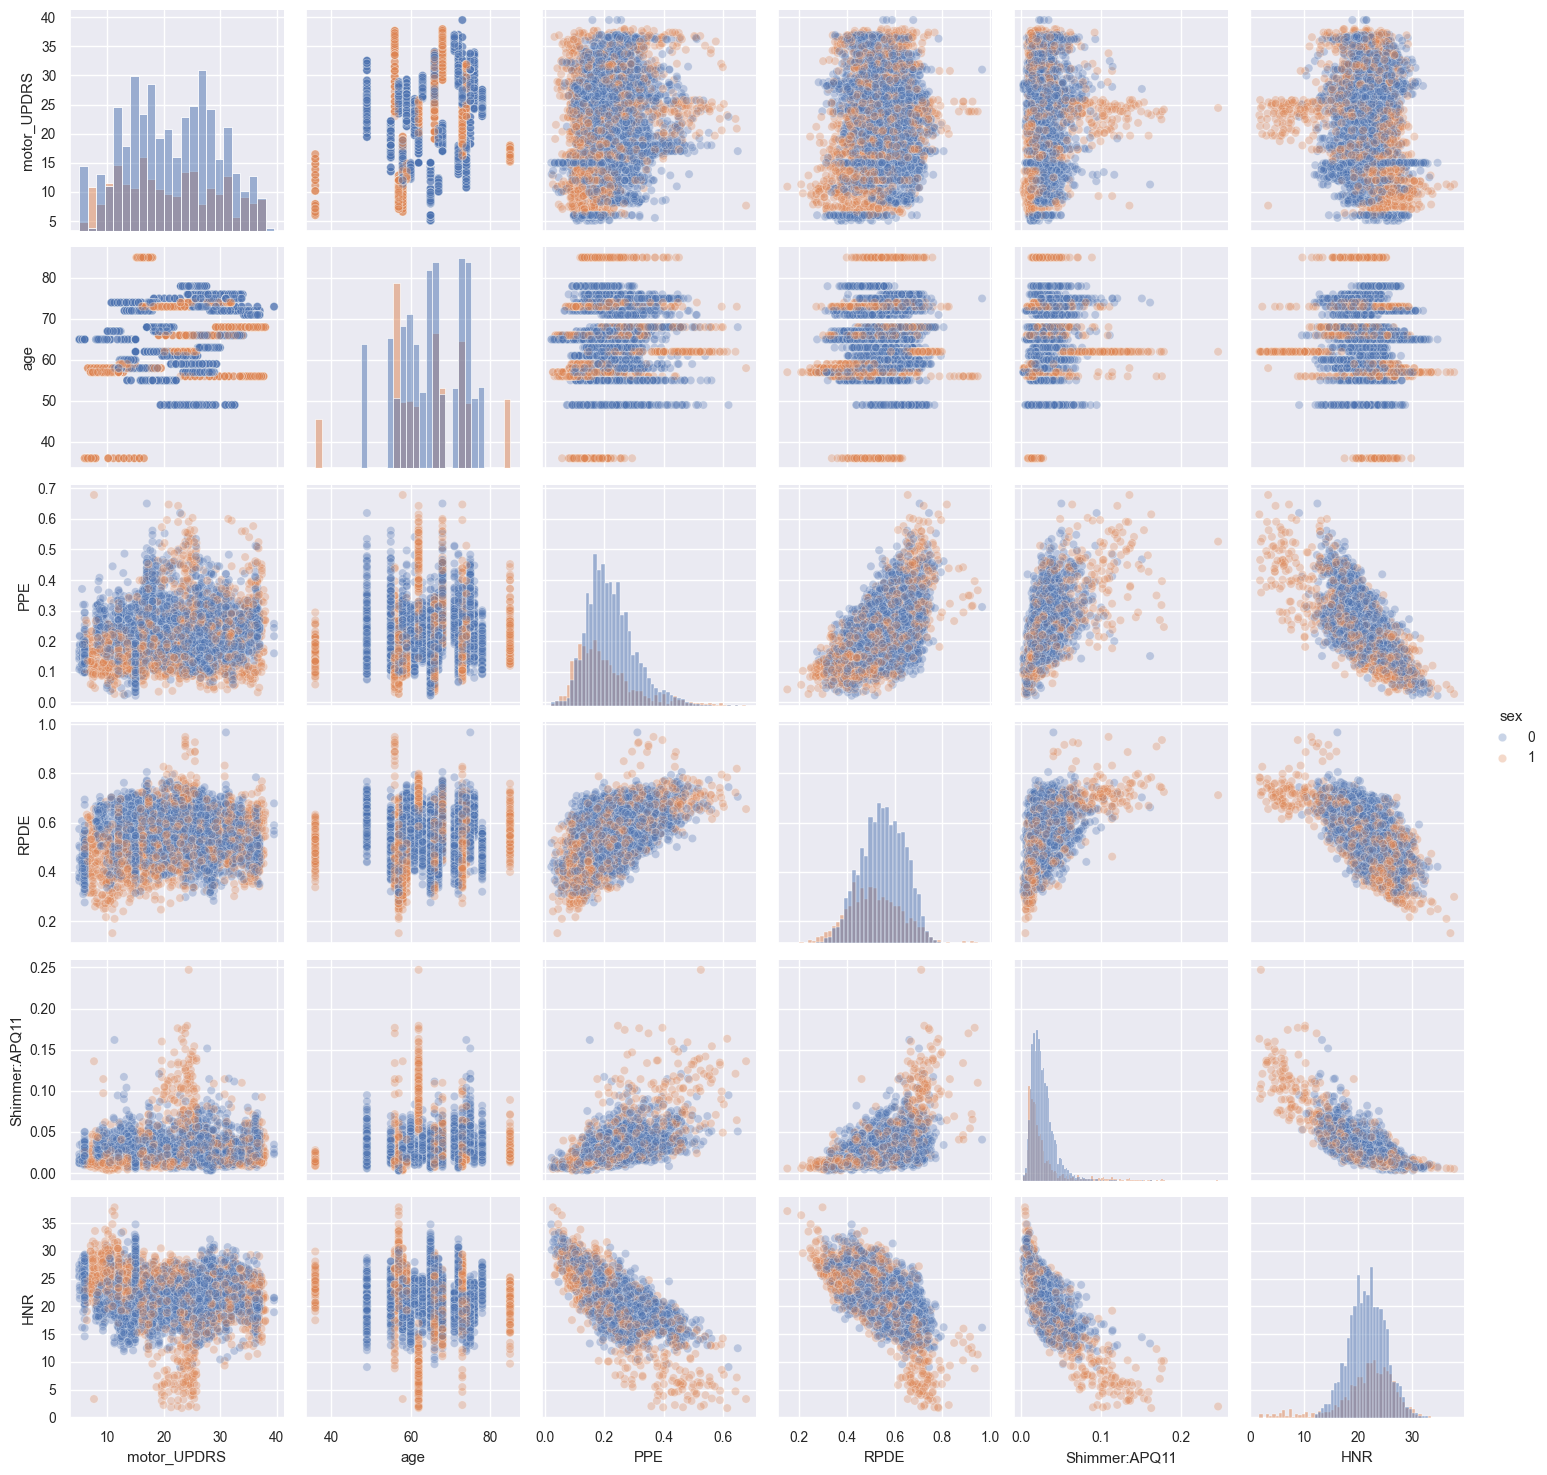

In [73]:
sns.pairplot(data[features], kind='scatter', diag_kind='hist', hue="sex", plot_kws=dict(alpha=0.3));

#### Now we'll plot all variables (except 'sex') against the target:

In [74]:
features = corr_matrix["motor_UPDRS"].sort_values(ascending=False).index
features = features.drop(["sex"])

#### Seaborn's regplot produces scatter plots with a linear regression model fit:

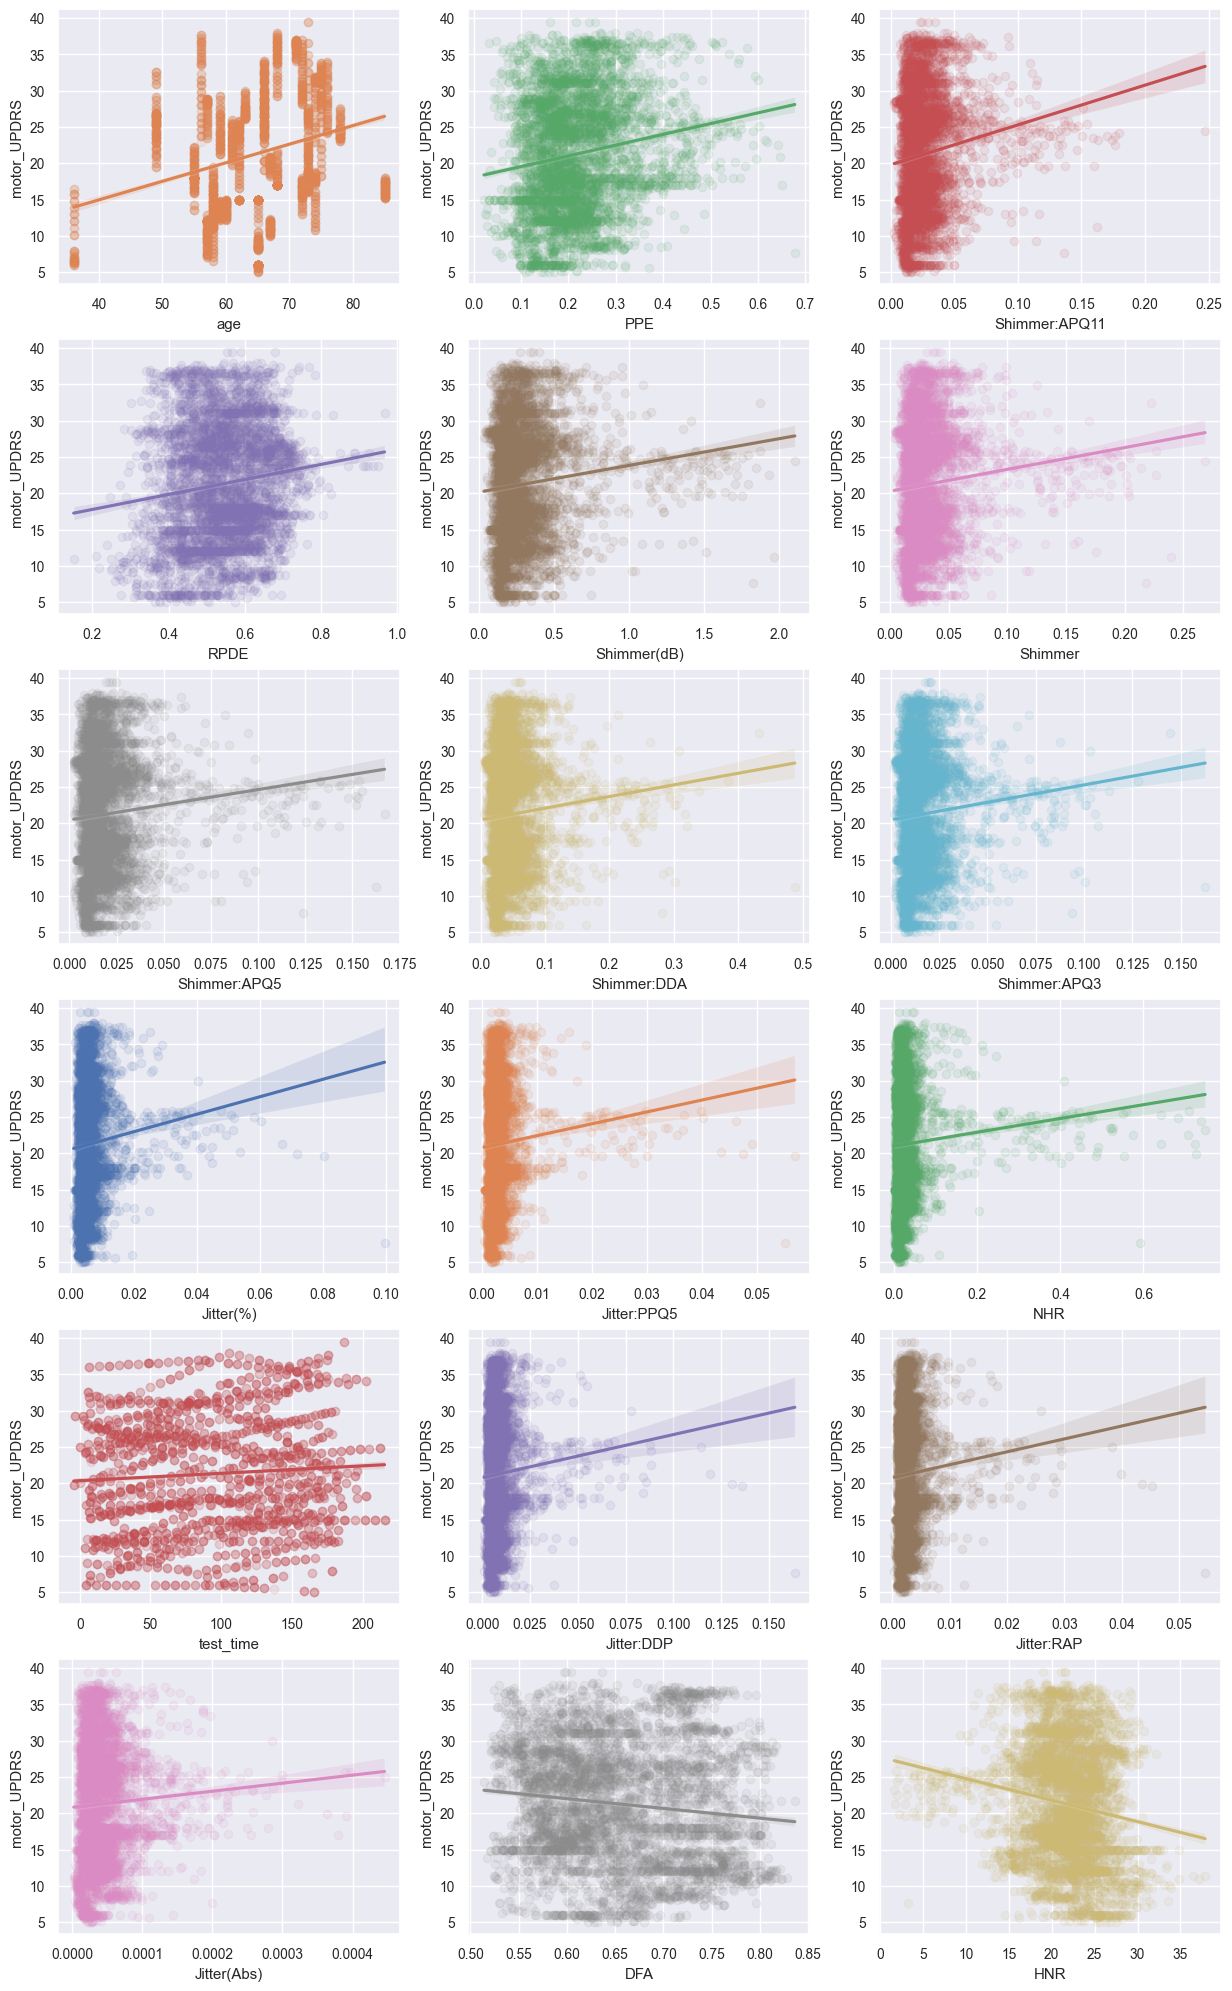

In [75]:
fig = plt.figure(figsize=(15,25))
for i in range(1, 19):
    ax = fig.add_subplot(6, 3, i)
    sns.regplot(x=features[i], y='motor_UPDRS', data=data, ax=ax, color=f'C{i}', scatter_kws={'alpha':0.1})